<a href="https://www.kaggle.com/code/olgatasenko/tags-pedictions?scriptVersionId=184182983" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!conda install -y gdown
!pip install wandb
!pip install pytorch_lightning
!pip install transformers

Channels:
 - rapidsai
 - nvidia
 - conda-forge
 - defaults
 - pytorch
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following NEW packages will be INSTALLED:

  packaging          conda-forge/noarch::packaging-24.1-pyhd8ed1ab_0 
  pluggy             conda-forge/noarch::pluggy-1.5.0-pyhd8ed1ab_0 
  requests           conda-forge/noarch::requests-2.32.3-pyhd8ed1ab_0 
  tqdm               conda-forge/noarch::tqdm-4.66.4-pyhd8ed1ab_0 




Preparing transaction: done
Verifying transaction: failed

RemoveError: 'packaging' is a dependency of conda and cannot be removed from
conda's operating environment.
RemoveError: 'pluggy' is a dependency of conda and cannot be removed from
conda's operating environment.
RemoveError: 'requests' is a dependency of conda and cannot be removed from
conda's operating environment.
RemoveError: 'tqdm' is a dependency of conda and cannot be removed from
conda's ope

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

import torch
from collections import Counter

import re
from nltk.tokenize import word_tokenize

import gdown

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Описание данных



In [4]:
url = "https://drive.google.com/drive/folders/138Mv-hhvm2e0tTODEomQiUt8CVBOA1mX?usp=sharing"
gdown.download_folder(url, quiet=True, use_cookies=False)

['/kaggle/working/project data/ria_news.csv',
 '/kaggle/working/project data/vk_comments.tsv',
 '/kaggle/working/project data/vk_news.tsv']

В таблице ria_news.csv лежат спарсенные данные с сайте РИА-НОВОСТИ с марта по декабрь 2018 года.
*   href - ссылка на новость
*   date - дата публикации
*   time - время публикации
*   title - заголовок
*   snippet - краткое описание
*   category - категория
*   keywords - ключевые слова

In [5]:
df_ria = pd.read_csv('/kaggle/working/project data/ria_news.csv', sep=';')
df_ria = df_ria[~df_ria.tags.isnull()]
print(df_ria.shape)
df_ria.head(3)

(153517, 7)


,href,date,time,title,snippet,category,tags
0,/20181231/1548961410.html,2018-12-31,"31 декабря 2018, 23:52",Нетаньяху не собирается в отставку в случае пр...,Премьер-министр Израиля Биньямин Нетаньяху не ...,В мире,"Биньямин Нетаньяху, Израиль, В мире"
1,/20181231/1548961364.html,2018-12-31,"31 декабря 2018, 23:19",Макрон в новогоднем обращении затронул тему ре...,"Результат реформ не может быть мгновенным, зая...",В мире,"Эммануэль Макрон, Франция, В мире"
2,/20181231/1548961218.html,2018-12-31,"31 декабря 2018, 23:06",СМИ: Кевину Спейси не разрешили отсутствовать ...,Суд в американском штате Массачусетс отверг хо...,В мире,"Кевин Спейси, США, В мире"


В таблице vk_news.tsv лежат данные о новостях, которые РИА запостили ВКонтакте с 2017 по 2019.
*   id - уникальный идентификатор поста
*   href - ссылка на сайт (если она была указана в посте)
*   datetime - дата и время публикации новости
*   title - заголовок новости
*   likes - число лайков под постом
*   comments - число комментариев под постом 

In [6]:
df_vk = pd.read_csv('/kaggle/working/project data/vk_news.tsv', sep='\t')
print(df_vk.shape)
df_vk.head(3)

(19928, 7)


,id,href,datetime,title,text,likes,comments
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",NaN,15,28
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",NaN,32,42
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",NaN,84,23


В таблице vk_comments.tsv лежат комментарии к новостям.

*   id - уникальный идентификатор комментария
*   post_id - идентификатор новости, под которой был оставлен комментарий
*   datetime - дата и время, когда был оставлен комментарий
*   text - текст комментария
*   likes - число лайков под комментарием

In [7]:
df_comments = pd.read_csv('/kaggle/working/project data/vk_comments.tsv', sep='\t')
df_comments = df_comments[~df_comments.text.isnull()]
print(df_comments.shape)
df_comments.head(3)

(2612629, 5)


,id,post_id,datetime,text,likes
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0


# Подготовка таргета

In [8]:
df_ria['tags'] = (df_ria.tags.apply(lambda w: ','.join([item.strip() for item in  w.lower().split(',')])))

tags = ','.join(list(df_ria.tags.values))
tags_cnt = Counter(tags.split(','))

print(len(tags_cnt))
tags_cnt.most_common()[:20]

9751


[('в мире', 50567),
 ('россия', 36844),
 ('спорт', 31719),
 ('происшествия', 18281),
 ('футбол', 17653),
 ('общество', 17232),
 ('экономика', 13772),
 ('сша', 13434),
 ('украина', 9432),
 ('политика', 7995),
 ('москва', 7334),
 ('хоккей', 5753),
 ('владимир путин', 5245),
 ('риа наука', 4642),
 ('чемпионат мира по футболу 2018', 4482),
 ('культура', 4165),
 ('туризм', 3667),
 ('великобритания', 3436),
 ('ситуация на украине', 3285),
 ('новости - чемпионат мира по футболу 2018', 3107)]

In [9]:
#Оставляем только теги, которые встречаются более 60 раз
target_tags = {tag for tag,cnt in tags_cnt.most_common() if cnt > 60}
len(target_tags)

697

In [10]:
# Закодируем теги для OHE.
tag2idx = dict(zip(target_tags, range(len(target_tags))))
idx2tag = {jtem: item for item,jtem in tag2idx.items()}

In [11]:
# Почистим таргет от лишних тэгов.
df_ria['target_tags'] = (df_ria.tags.apply(lambda w: [tag2idx.get(item) for item in  w.split(',') if item in target_tags]))

df_ria = df_ria[df_ria.target_tags.apply(len) > 0]
df_ria.shape

(153492, 8)

## 1.2 Подготовка текстов

In [12]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
def normalise_text(text):
    text = text.lower()
    text = re.sub('[^а-яa-z0-9 ]', '', text)
    return text.strip()

df_ria['title_clean'] = df_ria.title.apply(normalise_text)
df_vk['title_clean'] = df_vk.title.apply(normalise_text)

word_cnt = Counter(word_tokenize(' '.join(df_ria.title_clean.values)))

In [14]:
from nltk.corpus import stopwords

stops_ru = set(stopwords.words('russian'))

In [15]:
# удаляем стоп-слова
def create_vocab(text, stops_ru=stops_ru):

    word_cnt = Counter(word_tokenize(text))
    vocabulary = {"#PAD#": 0, "#UNKN#": 1}
    k = 2
    for word, _ in word_cnt.most_common():
        if word not in stops_ru:
            vocabulary[word] = k
            k += 1
    return vocabulary

# Отложенная выборка

In [16]:
ria_hrefs = set(df_ria.href.values)
vk_hrefs = set(df_vk.href.values)
test_hrefs = (vk_hrefs & ria_hrefs)

print('Размер отложенной выборки:', len(test_hrefs))

df = df_ria[~df_ria.href.isin(test_hrefs)]

Размер отложенной выборки: 1028


Пересечение лежит в декабре

In [17]:
df_ria[df_ria.href.isin(test_hrefs)].date.min(), df_ria[df_ria.href.isin(test_hrefs)].date.max()

('2018-12-06', '2018-12-31')

# Разбение на обучающую, валидационную и тестовую выборки

In [18]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

train_end_date = '2018-09-30'
val_end_date = '2018-11-30'
test_end_date = '2018-12-31'

df_test = df[(df['date'] > val_end_date) & (df['date'] <= test_end_date)]
df_val = df[(df['date'] > train_end_date) & (df['date'] <= val_end_date)]
df_train = df[df['date'] <= train_end_date]

In [19]:
df_train.head(3)

,href,date,time,title,snippet,category,tags,target_tags,title_clean
48577,/20180930/1529669120.html,2018-09-30,"30 сентября 2018, 23:59",Обвинившую Кавано в домогательствах американку...,<p><strong></strong></p>\n<p><strong>ВАШИНГТО...,В мире,"сша,в мире","[397, 257]",обвинившую кавано в домогательствах американку...
48578,/20180930/1529669084.html,2018-09-30,"30 сентября 2018, 23:57",Полиция сообщила об обстановке в башкирском се...,"<p><strong>УФА, 30 сен – РИА Новости.</strong...",Происшествия,"республика башкортостан,происшествия","[233, 438]",полиция сообщила об обстановке в башкирском се...
48579,/20180930/1142994754.html,2018-09-30,"30 сентября 2018, 23:55","Червиченко: ""Зенит"" в матче с ""Анжи"" подвели д...","""Зенит"" в воскресенье на выезде уступил ""Анжи""...",Спорт,"андрей червиченко,спорт,футбол","[489, 45]",червиченко зенит в матче с анжи подвели две ду...


In [20]:
print('Training set:', df_train['date'].min(), df_train['date'].max())
print('Validation set:', df_val['date'].min(), df_val['date'].max())
print('Test set:', df_test['date'].min(), df_test['date'].max())

Training set: 2018-03-15 00:00:00 2018-09-30 00:00:00
Validation set: 2018-10-01 00:00:00 2018-11-30 00:00:00
Test set: 2018-12-01 00:00:00 2018-12-31 00:00:00


Сформируем отложенную выборку (пересечение ВКонтакте и РИА).

In [21]:
df_oob = df_vk[df_vk.href.isin(test_hrefs)][['href', 'title_clean']]

df_ria_oob = df_ria[df_ria.href.isin(test_hrefs)][['href', 'target_tags']]
df_oob = df_oob.set_index('href').join(df_ria_oob.set_index('href')).reset_index()
df_oob.head(3)

,href,title_clean,target_tags
0,/20181231/1548960744.html,митрополит рязанский раскритиковал иронию судьбы,[251]
1,/20181231/1548958617.html,на украине позавидовали стене на границе с крымом,"[464, 257]"
2,/20181231/1548957394.html,в госдуме предложили отказаться от газа в жилы...,"[325, 325, 604, 659, 438]"


# Датасет

In [22]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class NewsDataset(Dataset):

    def __init__(self, target, title, vocab, vocab_size, max_title_len, max_classes):

       self.vocab = {word: idx  for word,idx in vocab.items() if idx < vocab_size}
       self.max_classes = max_classes
       self.y=self.target_ohe(target)
       self.X_title = self.create_text(title, max_title_len)


    def target_ohe(self, target):
        y = torch.zeros((len(target), self.max_classes))
        for i, t in enumerate(target):
            y[[i]*len(t), t] = 1.0
        return y

    def create_text(self, texts, max_len):
        result = [ ]
        for sent in texts:
            sent_tokenize = [self.vocab.get(item, 1) for item in word_tokenize(sent)]
            if len(sent_tokenize) >= max_len:
                sent_tokenize = sent_tokenize[:max_len]
            else:
                sent_tokenize += [0] * (max_len - len(sent_tokenize))
            result.append(sent_tokenize)
        return torch.tensor(result, dtype=torch.int)

    def __len__(self):
        return len(self.X_title)

    def __getitem__(self, idx):
        return (self.X_title[idx, :], self.y[idx])

In [23]:
CLASSES_NUM = len(idx2tag)
VOCAB_SIZE = 30000
MAX_TITLE_LEN = 20

# словарь создаем по всей выборке
vocabulary = create_vocab(' '.join(df_ria.title_clean.values))

In [24]:
# объявляем датасеты
train_dataset = NewsDataset(df_train.target_tags.values, df_train.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )
val_dataset = NewsDataset(df_val.target_tags.values, df_val.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )
test_dataset = NewsDataset(df_test.target_tags.values, df_test.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )

In [25]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=4)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=4096, num_workers=4)

## Архитектуры


In [26]:
from torch import nn
import torch.nn.functional as F

In [27]:
class SimpleClassifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, title):
        embedded = self.embedding(title)
        embedded = embedded.mean(dim=1)
        return self.fc(embedded)

In [28]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb_key")

In [29]:
import wandb
from pytorch_lightning.loggers import WandbLogger
wandb.login(key=wandb_api)

wandb: Currently logged in as: tasenko_03. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# pytorch_lightning модуль для обучения

In [30]:
import pytorch_lightning as pl

class TrainLightningModule(pl.LightningModule):
    def __init__(self, model, learning_rate, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate

    def forward(self, title):
        result = self.model(title)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        title, target = train_batch

        logits = self.model(title)
        loss = self.criterion(logits, target)
        self.log(
            "train_loss", loss, prog_bar=True
        )

        wandb.log({"train_loss": loss})

        return loss

    def validation_step(self, val_batch, batch_idx):
        title, target = val_batch

        logits = self.model(title)
        loss = self.criterion(logits, target)
        self.log(
            "val_loss", loss, prog_bar=True
        )

        wandb.log({"validation_loss": loss})

        return loss

# Обучение модели

In [31]:
EMBEDDING_DIM = 300
EPOCHS = 7
LR = 1e-3

In [32]:
wandb_logger = WandbLogger(name='Model', log_model='all')
model_baseline = SimpleClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
criterion = torch.nn.CrossEntropyLoss()

train_module =TrainLightningModule(model_baseline, LR, criterion)

trainer = pl.Trainer(logger=wandb_logger, accelerator="gpu", max_epochs=EPOCHS)
trainer.fit(train_module, train_dataloader, val_dataloader)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [33]:
wandb.finish()

epoch,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██████
train_loss,█▇▇▇▆▆▅▄▄▄▄▄▂▃▃▃▄▃▂▂▂▂▃▃▂▂▂▂▁▂▃▂▁▁▂▁▁▃▁▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
val_loss,█▅▃▂▁▁▁
validation_loss,█▇▃▃▃▃▃▃▂▂▄▂▂▂▂▂▂▂▃▂▂▃▁▁▁▂▂▂▁▃▂▂▃▁▁▁▁▂▂▁
epoch,6
train_loss,6.04171
trainer/global_step,11479
val_loss,7.89574
validation_loss,6.29282


# Оценка качества

In [34]:
def precision(target, y_pred):
    num = ((y_pred == 1) & (target == 1)).sum(dim=1)
    denum = (y_pred == 1).sum(dim=1)
    return (num/(denum + 1e-5)).mean().item()

def recall(target, y_pred):
    num = ((y_pred == 1) & (target == 1)).sum(dim=1)
    denum = (target == 1).sum(dim=1)
    return (num/(denum + 1e-5)).mean().item()

In [35]:
def get_predict(model, dataset):
    dataloader = DataLoader(dataset, shuffle=False, batch_size=dataset.__len__())
    first_batch = next(iter(dataloader))
    
    pred_prob, target = None, None
    for title, target in dataloader:
        logit = model_baseline(title)
        pred_prob = F.softmax(logit, dim=1)

    return pred_prob, target

In [36]:
# функция для поиска наилучшего значения порога для метрики precision
def find_optimal_threshold_precision(model, dataset):
    pred_prob, target = get_predict(model, dataset)

    best_precision = 0.0
    optimal_threshold = 0.0

    for threshold in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.5]:
        y_pred = (pred_prob > threshold).float()

        current_precision = precision(target, y_pred)

        if current_precision > best_precision:
            best_precision = current_precision
            optimal_threshold = threshold

    return optimal_threshold, best_precision

In [37]:
optimal_threshold, best_precision = find_optimal_threshold_precision(model_baseline, val_dataset)

print(f"Optimal Threshold: {optimal_threshold}")
print(f"Best Precision: {best_precision}")

Optimal Threshold: 0.1
Best Precision: 0.7777279019355774


In [38]:
# making predictions using baseline model
y_prob_baseline, target = get_predict(model_baseline, test_dataset)
y_pred_baseline = 1*(y_prob_baseline > optimal_threshold)

print('Precision for Baseline Model:', precision(target, y_pred_baseline))
print('Recall for Baseline Model:', recall(target, y_pred_baseline))

Precision for Baseline Model: 0.682787299156189
Recall for Baseline Model: 0.6240801215171814


# Прогнозы для отложенной выборки

In [39]:
oob_dataset = NewsDataset(df_oob.target_tags.values, df_oob.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM)

baseline_pred_prob, baseline_target = get_predict(model_baseline, oob_dataset)
baseline_y_pred = 1 * (baseline_pred_prob > optimal_threshold)

precision_baseline = precision(baseline_target, baseline_y_pred)
recall_baseline = recall(baseline_target, baseline_y_pred)

print('Baseline Model Metrics on Intersection of RIA and VK:')
print(f'Precision: {precision_baseline}')
print(f'Recall: {recall_baseline}')

Baseline Model Metrics on Intersection of RIA and VK:
Precision: 0.6015161871910095
Recall: 0.578951895236969


# Cентимент-классификатор

In [44]:
from transformers import pipeline
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = pipeline(model="seara/rubert-tiny2-russian-sentiment", device=device)

In [45]:
print(df_comments.shape)
df_comments.head(3)

(2612629, 5)


,id,post_id,datetime,text,likes
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0


In [46]:
def analyze_sentiment(comment):
    result = model(comment)
    return {'sentiment_verdict': result[0]['label'], 'sentiment_score': result[0]['score']}

In [48]:
sentiment_verdict = []
sentiment_score = []

for i, comment in enumerate(df_comments['text']):
    try:
        sentiment_result = analyze_sentiment(comment)
        if i % 250000 == 0:
            print(f"Processed {i} comments. Last sentiment result: {sentiment_result}")
        sentiment_verdict.append(sentiment_result['sentiment_verdict'])
        sentiment_score.append(sentiment_result['sentiment_score'])
    except RuntimeError:
        sentiment_verdict.append('Nan')
        sentiment_score.append(0.0)

Processed 0 comments. Last sentiment result: {'sentiment_verdict': 'neutral', 'sentiment_score': 0.9122462868690491}
Processed 250000 comments. Last sentiment result: {'sentiment_verdict': 'neutral', 'sentiment_score': 0.8866508603096008}
Processed 500000 comments. Last sentiment result: {'sentiment_verdict': 'neutral', 'sentiment_score': 0.8869845867156982}
Processed 750000 comments. Last sentiment result: {'sentiment_verdict': 'neutral', 'sentiment_score': 0.5133083462715149}
Processed 1000000 comments. Last sentiment result: {'sentiment_verdict': 'neutral', 'sentiment_score': 0.8997182846069336}
Processed 1250000 comments. Last sentiment result: {'sentiment_verdict': 'neutral', 'sentiment_score': 0.6473388671875}
Processed 1500000 comments. Last sentiment result: {'sentiment_verdict': 'neutral', 'sentiment_score': 0.7573750615119934}
Processed 1750000 comments. Last sentiment result: {'sentiment_verdict': 'positive', 'sentiment_score': 0.8377580046653748}
Processed 2000000 comments.

In [50]:
df_comments['sentiment_verdict'] = sentiment_verdict
df_comments['sentiment_score'] = sentiment_score

# Аналитика

In [51]:
# пропорция положительных и отрицательных комментариев
positive_comments = (df_comments['sentiment_verdict'] == "positive").mean()
negative_comments = (df_comments['sentiment_verdict'] == "negative").mean()
neutral_comments = (df_comments['sentiment_verdict'] == "neutral").mean()

print(f'Пропорция положительных комментариев = {positive_comments}')
print(f'Пропорция отрицательных комментариев = {negative_comments}')
print(f'Пропорция нейтральных комментариев = {neutral_comments}')

Пропорция положительных комментариев = 0.0720014207910882
Пропорция отрицательных комментариев = 0.22876344096310652
Пропорция нейтральных комментариев = 0.6991846144247805


In [52]:
# объединение комментариев с соответствующей новостью
merged_df = df_comments.merge(df_vk, left_on='post_id', right_on='id', how='left')
print(merged_df.shape)
merged_df.head(3)

(2612629, 15)


,id_x,post_id,datetime_x,text_x,likes_x,sentiment_verdict,sentiment_score,id_y,href,datetime_y,title,text_y,likes_y,comments,title_clean
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0,neutral,0.912246,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",NaN,15,28,в днр заявили о задержании диверсантов причаст...
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0,neutral,0.879370,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",NaN,15,28,в днр заявили о задержании диверсантов причаст...
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0,positive,0.676261,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",NaN,15,28,в днр заявили о задержании диверсантов причаст...


In [53]:
# подсчет количества комментариев
comment_counts = merged_df.groupby(['post_id', 'sentiment_verdict']).size().unstack(fill_value=0)

In [54]:
df_vk_with_counts = pd.merge(df_vk, comment_counts, left_on='id', right_index=True, how='left')
df_vk_with_counts.drop(['Nan', 'comments'], axis=1, inplace=True)

print(df_vk_with_counts.shape)
df_vk_with_counts.head(3)

(19928, 10)


,id,href,datetime,title,text,likes,title_clean,negative,neutral,positive
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",NaN,15,в днр заявили о задержании диверсантов причаст...,10.0,35.0,2.0
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",NaN,32,житель урала заминировал тц изза снятия сотов...,11.0,28.0,3.0
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",NaN,84,в черном море нашли потерянный флот гитлера,4.0,15.0,3.0


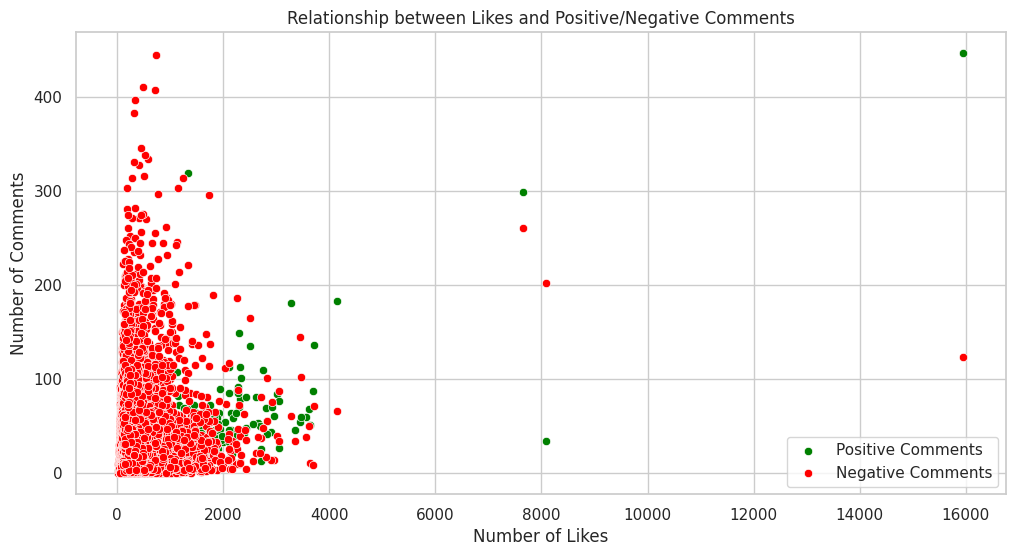

In [55]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.scatterplot(x='likes', y='positive', data=df_vk_with_counts, label='Positive Comments', color='green')
sns.scatterplot(x='likes', y='negative', data=df_vk_with_counts, label='Negative Comments', color='red')
#sns.scatterplot(x='likes', y='neutral', data=df_vk_with_counts, label='Neutral Comments', color='blue')
plt.title('Relationship between Likes and Positive/Negative Comments')
plt.xlabel('Number of Likes')
plt.ylabel('Number of Comments')
plt.legend()
plt.show()

Новости с меньшим количеством лайков получают значительно больше комментариев.

# Предсказание категории

In [56]:
import joblib

reg = joblib.load('/kaggle/input/model-cat/pipe.joblib')

predictions = reg.predict(df_vk_with_counts['title_clean'])
df_vk_with_counts['catagory'] = predictions

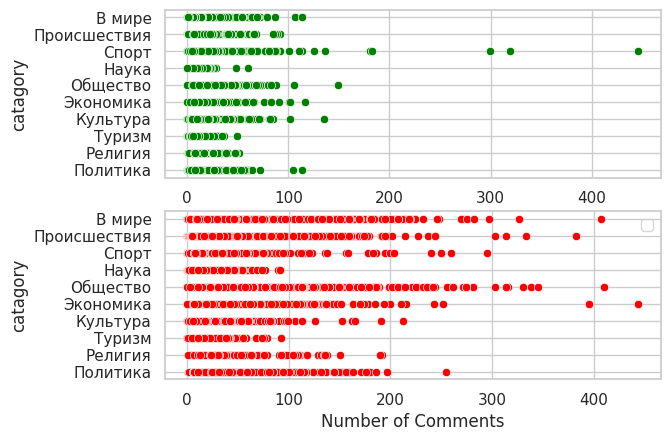

In [57]:
figure, axis = plt.subplots(2) 
sns.scatterplot(ax=axis[0], x='positive', y='catagory', data=df_vk_with_counts, color='green')
sns.scatterplot(ax=axis[1], x='negative', y='catagory', data=df_vk_with_counts, color='red')
plt.xlabel('Number of Comments')
plt.legend()
plt.show()

Категории "общество", "экономика", "происшедствия" и "в мире" получают болььше положительных комментарией, категория "спорт" 

# Теперь посмотрим на теги

In [69]:
df_vk['target_tags'] = [[0]]*df_vk.shape[0]

vk_dataset = NewsDataset(df_vk.target_tags.values, df_vk.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM)

In [70]:
y_prob_baseline, target = get_predict(model_baseline, vk_dataset)
y_pred_baseline = 1*(y_prob_baseline > optimal_threshold)

In [60]:
import random

In [90]:
predicted_classes = []
for line in list(y_pred_baseline):
    winner = np.argwhere(line == np.amax(np.asarray(line)))
    winner = winner.flatten().tolist()
    if len(winner) > 6:
        predicted_classes.append(random.sample(winner, 6))
    else:
        predicted_classes.append(winner)

In [91]:
df_vk_with_counts['target_tags'] = predicted_classes

In [97]:
df_vk_with_counts['tags_words'] = (df_vk_with_counts.target_tags.apply(lambda w: [idx2tag.get(item) for item in w]))

In [98]:
df_vk_with_counts.head(4)

,id,href,datetime,title,text,likes,title_clean,negative,neutral,positive,catagory,target_tags,tags_words
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",NaN,15,в днр заявили о задержании диверсантов причаст...,10.0,35.0,2.0,В мире,"[135, 174, 257]","[донецкая народная республика, ситуация в днр ..."
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",NaN,32,житель урала заминировал тц изза снятия сотов...,11.0,28.0,3.0,Происшествия,[438],[происшествия]
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",NaN,84,в черном море нашли потерянный флот гитлера,4.0,15.0,3.0,В мире,[257],[в мире]
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,NaN,58,в сша освободили задержанную российскую актрис...,10.0,28.0,2.0,В мире,"[257, 397, 659]","[в мире, сша, россия]"


**Посмотрим на категорию "Общество", так как в этой категории больше всего негативных комментариев**

In [84]:
society = df_vk_with_counts[['tags_words', 'negative', 'positive']].loc[df_vk_with_counts['catagory'] == 'Общество']

In [102]:
society['tags_words'] = [tuple(x) for x in society.tags_words.values]

In [108]:
grouped_data = society.groupby("tags_words").agg(negative_count=("negative", sum), positive_count=("positive", sum))
grouped_data.sort_values(by='negative_count', ascending=False)

,negative_count,positive_count
tags_words,,
"(общество, россия)",27904.0,8449.0
"(россия,)",5641.0,1653.0
"(владимир путин, общество, россия)",5045.0,1677.0
"(общество, госдума рф, россия)",4598.0,1250.0
"(общество,)",4175.0,1599.0
...,...,...
"(общество, экология)",1.0,10.0
"(риа наука, происшествия, россия)",1.0,0.0
"(матчи 1/4 финала лиги европы-2017/2018 между цска и английским ""арсеналом"", открытия - риа наука, эльвира набиуллина, станислав черчесов, убийство фигуриста дениса тена, малайзия)",1.0,5.0


Больше всего негативных комментариев достаточно в стандартных категориях, ничего удивительного